# Load config

In [1]:
import yaml 

def get_data_from_yaml(filename):
    try:
        with open(filename, 'r') as f:
            data = yaml.safe_load(f)
    except IOError:
        raise IOError(f"Error opening file: {filename}")

    return data

# Example usage
config = get_data_from_yaml("../config.yaml")

# Access data based on its structure (e.g., dictionary)
if isinstance(config, dict):
    print(config)
    CLASSES = config.get("classes")
    MINIO_SERVER = config.get("minio")["server"]
    MINIO_DATA_LABELED = config.get("minio")["data_labeled"]
    MINIO_MODEL_TRAINED = config.get("minio")["model_trained"]
    VNCORENLP_DIR = config.get("vncorenlp")["save_dir"]
else:
    print("Config is not a dictionary")

{'device': 'cuda:0', 'classes': ['khac', 'phan_dong', 'thu_ghet', 'khieu_dam'], 'vocab': 'aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ', 'minio': {'server': '172.18.0.2:9000', 'data_labeled': 'data-annotated', 'model_trained': 'model'}, 'vncorenlp': {'save_dir': '/home/anhcd/Software/VnCoreNLP/'}}


# Load data

In [2]:
from minio import Minio

minio_client = Minio(
    endpoint=MINIO_SERVER,
    access_key="vivas",
    secret_key="pad12345",
    secure=False
)

# Check if the "data" bucket exists
bucket_names = [MINIO_DATA_LABELED, MINIO_MODEL_TRAINED]
for bucket_name in bucket_names:
    found = minio_client.bucket_exists(bucket_name)

    if not found:
        # Create the "data" bucket
        minio_client.make_bucket(bucket_name)
        print(f"Bucket '{bucket_name}' created successfully.")
    else:
        print(f"Bucket '{bucket_name}' already exists.")

Bucket 'data-annotated' already exists.
Bucket 'model' already exists.


Get all file in bucket

In [3]:
from io import BytesIO
import pandas as pd

storage_options = {"client_kwargs": {"endpoint_url": MINIO_SERVER}}
objects = minio_client.list_objects(MINIO_DATA_LABELED, recursive=True)

dataframes = []

for obj in objects:
    print(obj.object_name)
    response = minio_client.get_object(MINIO_DATA_LABELED, obj.object_name)
    file_data = BytesIO(response.read())
    response.close()
    response.release_conn()
    df = pd.read_csv(file_data)
    df = df[['text', 'label']]
    dataframes.append(df)

chong_pha_nha_nuoc.xlsx - Sheet1.csv
ngon_tu_phan_cam_all.xlsx - Sheet1.csv
van_ban_khieu_dam.xlsx - Sheet1.csv


In [4]:
df = pd.concat(dataframes)
df = df.dropna()
df

text      label
0      BẮT 3 CỰU TRƯỞNG PHÒNG GDĐT VÌ NHẬN HỐI LỘ Phò...  phan_dong
1      Vụ Phó Hiệu Trưởng trường bị chồng của Chủ Tịc...  phan_dong
2      Chi hơn 200 tỷ đồng cho kỷ niệm ngày sinh của ...  phan_dong
3      Đảng cộng sản tuyên bố không tin Trời Phật như...  phan_dong
4                                         Rất bất thường       khac
...                                                  ...        ...
12432  – Ahhh!!! Anh chịu hết nổi rồi… Chắc anh ra… m...       khac
12433  Nói xong nàng gồng người xuất tinh chan chứa. ...  khieu_dam
12434  Tôi ghì chặt lấy Hương một lúc lâu cho đến khi...  khieu_dam
12435  – Không chịu! Anh nói là xuất tinh cho em thấy...  khieu_dam
12436  Nói xong tôi hôn lên môi nàng một lần nữa, rồi...       khac

[18124 rows x 2 columns]

In [5]:
import py_vncorenlp

# Load the word and sentence segmentation component
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=['wseg'], save_dir=VNCORENLP_DIR)

def process_row(row):
    # Kiểm tra xem label có hợp lệ không 
    if row['label'] in CLASSES:
        content = rdrsegmenter.word_segment(row['text'])
        content = ''.join(content)
        print(content)
        return content
    else:
        # Nếu label không hợp lệ, thay đổi text
        return None

df['text'] = df.apply(process_row, axis=1)

2024-07-01 15:10:40 INFO  WordSegmenter:24 - Loading Word Segmentation model
BẮT 3 CỰU TRƯỞNG PHÒNG GDĐT VÌ NHẬN HỐI_LỘ Phòng Cảnh_sát điều_tra tội_phạm về tham_nhũng kinh_tế buôn_lậu môi_trường Công_an tỉnh Quảng_Nam đã tống_đạt các quyết_định khởi_tố bị_can bắt tạm giam 3 cựu Trưởng phòng GDĐT tại 3 huyện Các bị_can gồm Lê_Kim_Vân cựu Trưởng phòng GDĐT huyện Tây_Giang Nguyễn_Tấn_Lộc_Chánh Văn_phòng huyện_uỷ cựu Trưởng phòng GDĐT huyện Nam_Giang và Nguyễn_Thanh_Tùng_Chủ_tịch Liên_đoàn lao_động huyện cựu Trưởng phòng GDĐT huyện Bắc_Trà_My Động_thái trên là kết_quả mở_rộng điều_tra vụ án đưa và nhận hối_lộ xảy ra tại các Phòng GDĐT tại tỉnh Quảng_Nam Giáo_dục là ngành mũi_nhọn tiên_phong mà giờ bắt toàn các trưởng phòng thế_này thì không biết sẽ giáo_dục nổi ai Hay_là muốn biến các thế_hệ trẻ những mầm_non tương_lai trở_thành thế_hệ kế_nhiệm chỉ biết tham_ô và hối_lộ Một đất_nước mà không chú_trọng về giáo_dục bỏ_bê để cho những kẻ trong ngành muốn làm_sao thì làm thì người_dân còn hi_v

In [6]:
df = df.dropna()
df

text      label
0      BẮT 3 CỰU TRƯỞNG PHÒNG GDĐT VÌ NHẬN HỐI_LỘ Phò...  phan_dong
1      Vụ Phó Hiệu_Trưởng trường bị chồng của Chủ_Tịc...  phan_dong
2      Chi hơn 200 tỷ đồng cho kỷ_niệm ngày_sinh của ...  phan_dong
3      Đảng cộng_sản tuyên_bố không tin Trời Phật như...  phan_dong
4                                         Rất bất_thường       khac
...                                                  ...        ...
12432  – Ahhh !!!Anh chịu hết_nổi rồi …Chắc anh ra … ...       khac
12433  Nói xong nàng gồng người xuất_tinh chan_chứa ....  khieu_dam
12434  Tôi ghì chặt lấy Hương một lúc lâu cho đến khi...  khieu_dam
12435  – Không chịu !Anh nói là xuất_tinh cho em thấy...  khieu_dam
12436  Nói xong tôi hôn lên môi nàng một lần nữa , rồ...       khac

[13295 rows x 2 columns]

HỐI _ LỘ 
HỐI_LỘ
Hiệu_Trưởng
Hiệu _ Trưởng

In [7]:
df.to_csv("/home/anhcd/Products/kiem-duyet-noi-dung-van-ban-tieng-viet/data/data_all.csv")

# Train - Test split

In [1]:
import pandas as pd

df = pd.read_csv("/home/anhcd/Products/kiem-duyet-noi-dung-van-ban-tieng-viet/data/data_all.csv")

In [7]:
label_counts = df['label'].value_counts()
print(label_counts)

label
khac         8995
khieu_dam    3845
phan_dong     441
thu_ghet       14
Name: count, dtype: int64


In [9]:
df

Unnamed: 0                                               text  \
0               0  BẮT 3 CỰU TRƯỞNG PHÒNG GDĐT VÌ NHẬN HỐI_LỘ Phò...   
1               1  Vụ Phó Hiệu_Trưởng trường bị chồng của Chủ_Tịc...   
2               2  Chi hơn 200 tỷ đồng cho kỷ_niệm ngày_sinh của ...   
3               3  Đảng cộng_sản tuyên_bố không tin Trời Phật như...   
4               4                                     Rất bất_thường   
...           ...                                                ...   
13290       12432  – Ahhh !!!Anh chịu hết_nổi rồi …Chắc anh ra … ...   
13291       12433  Nói xong nàng gồng người xuất_tinh chan_chứa ....   
13292       12434  Tôi ghì chặt lấy Hương một lúc lâu cho đến khi...   
13293       12435  – Không chịu !Anh nói là xuất_tinh cho em thấy...   
13294       12436  Nói xong tôi hôn lên môi nàng một lần nữa , rồ...   

           label  
0      phan_dong  
1      phan_dong  
2      phan_dong  
3      phan_dong  
4           khac  
...          ...  
13290       khac  
13291  khieu_dam  
13292  khieu_dam  
13293  khieu_dam  
13294       khac  

[13295 rows x 3 columns]

In [2]:
from sklearn.model_selection import train_test_split

# Sử dụng train_test_split để phân chia dữ liệu
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)

# Kiểm tra kết quả
print(f"Train DataFrame size: {train_df.shape}")
print(f"Test DataFrame size: {test_df.shape}")

Train DataFrame size: (14479, 3)
Test DataFrame size: (3620, 3)


In [3]:
train_df

Unnamed: 0                                               text  \
13060         444  Đói _ khổ vẫn hoàn đói _ khổ Nghèo _ rớt _ mồn...   
10195        7526  Tran_Dan , nho ong tien doan khi nao Nancy P. ...   
17870       12207  Ánh_sáng trong phòng mờ_mờ ảo ảo rất gợi_tình ...   
16978       10076  Đợt nhà mình với mấy dì dưỡng đi vũng_tàu chơi...   
15258        5206                                     Má ba thật quá   
...           ...                                                ...   
9590         6921                             : > > củng là hoa chắc   
6196         3527                 Chị giàu chị nói Cc gì chả đúng ..   
12859         243  Ngày _ xưa đất _ nước ta còn khổ trùng quốc đô...   
13285         858                                         Hài _ hước   
12810         194                                                  Z   

           label  
13060  khieu_dam  
10195       khac  
17870       khac  
16978  khieu_dam  
15258       khac  
...          ...  
9590        khac  
6196    phan_cam  
12859       khac  
13285  khieu_dam  
12810       khac  

[14479 rows x 3 columns]

In [5]:
test_df

Unnamed: 0                                               text  \
1634         1635  Thái _ lan có văn _ hoá lễ _ hội tạt nước lâu ...   
11718        9050             Cho hỏi đây la 1 quần hay 2 quần ạ ???   
10813        8145  Chua thay thang bede nao sau nhu thang quy nay...   
17415       11608  Cứ cầm chim xong chọc vào bướm em Mai ngoài qu...   
5295         2626  Sao mấy bài viết tội _ trạng của cán _ bộ lãnh...   
...           ...                                                ...   
3720         1051                                          Súc _ vật   
18069       12407  Tuy rất muốn đưa ngay con chim của mình vào cá...   
6847         4178  Mấy anh _ chị _ em đẹp _ trai xinh gái vào lik...   
11727        9059  Em là một đứa xem chùa mà vẫn được fan cứng , ...   
16394        8370  Đang nói đến sự bịa _ đặt của từ _ thiên_đường...   

           label  
1634        khac  
11718       khac  
10813   phan_cam  
17415  khieu_dam  
5295    phan_cam  
...          ...  
3720    phan_cam  
18069  khieu_dam  
6847        khac  
11727       khac  
16394  khieu_dam  

[3620 rows x 3 columns]

<Axes: xlabel='label', ylabel='count'>

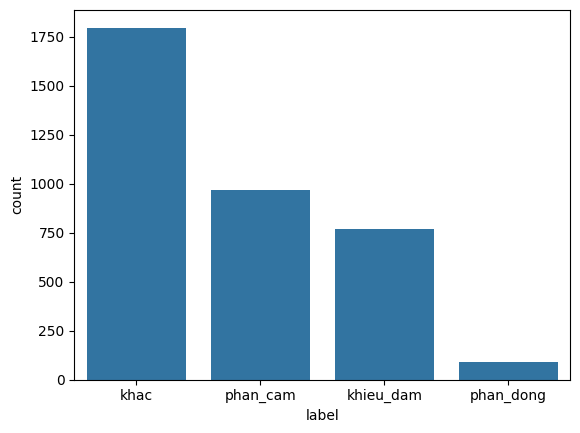

In [7]:
import seaborn as sns

sns.countplot(x='label', data=test_df)